In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.compose import make_column_transformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.base import TransformerMixin
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, brier_score_loss
from catboost import CatBoostRegressor 
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import KFold
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, GradientBoostingRegressor
import shap

In [2]:
# !pip install catboost
# !pip install shap

In [3]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/AML_Final_report')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


MODEL could deal with text data: catboost, lightgbm

In [4]:
train= pd.read_csv('processed_train_without_ohe.csv')
test = pd.read_csv('processed_test_without_ohe.csv')

y = pd.read_csv('label_train.csv')
y = y.squeeze()
cat_cols = ['original_language','status','weekday','day','month']

In [5]:
train.original_language = train.original_language.astype('category')
train.status = train.status.astype('category')
train.weekday = train.weekday.fillna(train.weekday.value_counts().index[0]).astype(int).astype('category')
train.day = train.day.fillna(train.day.value_counts().index[0]).astype(int).astype('category')
train.month = train.month.fillna(train.month.value_counts().index[0]).astype(int).astype('category')

test.original_language = test.original_language.astype('category')
test.status = test.status.fillna('Rumored')
test.status = test.status.astype('category')
test.weekday = test.weekday.fillna(test.weekday.value_counts().index[0]).astype(int).astype('category')
test.day = test.day.fillna(test.day.value_counts().index[0]).astype(int).astype('category')
test.month = test.month.fillna(test.month.value_counts().index[0]).astype(int).astype('category')

In [6]:
k=10
kf = KFold(n_splits=k,
            shuffle=True,
            random_state=int(time.time()))

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in kf.split(np.zeros(len(y)), # Placeholder (dummy input)
                                          y): # True input
    
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)

In [7]:
preds_train = np.zeros([len(train),k])
preds_val = np.zeros([len(list_of_valid_index[0]),k])
preds_test = np.zeros([len(test),k])

log_rmse_train = []
log_rmse_val = []

In [8]:
def model_train(model):
    for j in tqdm(range(k)):   
        x_train = train.loc[list_of_train_index[j], :]
        x_valid = train.loc[list_of_valid_index[j], :]
        
        y_true_train = y[list_of_train_index[j]]
        y_true_valid = y[list_of_valid_index[j]]

        model.fit(x_train,y_true_train)
        preds_train[:,j] = model.predict(train)
        preds_val[:,j] = model.predict(x_valid)
        preds_test[:,j] = model.predict(test)
        
        log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
        log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
    return preds_test,log_rmse_train,log_rmse_val

In [9]:
def submission(preds_test):
    final_preds = preds_test.mean(axis=1)
    sub = pd.read_csv('sample_submission.csv')
    sub.revenue = np.exp(final_preds)
    sub.to_csv('sub_hist.csv',index=False)
    return final_preds,sub

Lightgbm 

In [10]:
lgb_m = lgb.LGBMRegressor()
pred_test_lgb,log_rmse_train_lgb,log_rmse_val_lgb = model_train(lgb_m)
print('train score:',np.mean(log_rmse_train_lgb), 'validation score:',np.mean(log_rmse_val_lgb))
result = submission(pred_test_lgb)[0]

100%|██████████| 10/10 [00:07<00:00,  1.33it/s]

train score: 1.0119434547870279 validation score: 2.1485843870445533


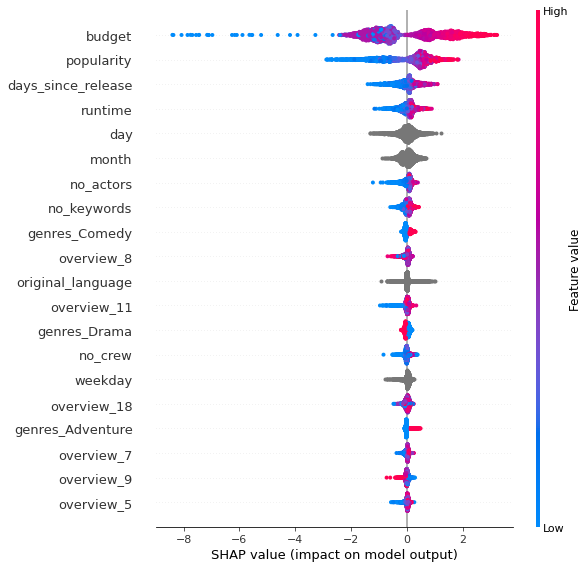

In [11]:
explainer = shap.TreeExplainer(lgb_m)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

In [12]:
def model_cat(model):
    for j in tqdm(range(k)):   
        x_train = train.loc[list_of_train_index[j], :]
        x_valid = train.loc[list_of_valid_index[j], :]
        
        y_true_train = y[list_of_train_index[j]]
        y_true_valid = y[list_of_valid_index[j]]

        model.fit(x_train,y_true_train,cat_features = cat_cols)
        preds_train[:,j] = model.predict(train)
        preds_val[:,j] = model.predict(x_valid)
        preds_test[:,j] = model.predict(test)
        
        log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
        log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
    return preds_test,log_rmse_train,log_rmse_val

In [13]:
cat = CatBoostRegressor()
pred_test_cat,log_rmse_train_cat,log_rmse_val_cat = model_cat(cat)
print('train score:',np.mean(log_rmse_train_cat), 'validation score:',np.mean(log_rmse_val_cat))
result = submission(pred_test_cat)[0]

  0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.0479
0:	learn: 2.9702722	total: 62.7ms	remaining: 1m 2s
1:	learn: 2.9148080	total: 75.7ms	remaining: 37.8s
2:	learn: 2.8658595	total: 89.1ms	remaining: 29.6s
3:	learn: 2.8203237	total: 105ms	remaining: 26.3s
4:	learn: 2.7776005	total: 118ms	remaining: 23.5s
5:	learn: 2.7382583	total: 130ms	remaining: 21.6s
6:	learn: 2.7047165	total: 144ms	remaining: 20.4s
7:	learn: 2.6685662	total: 157ms	remaining: 19.4s
8:	learn: 2.6380332	total: 170ms	remaining: 18.7s
9:	learn: 2.6062421	total: 183ms	remaining: 18.1s
10:	learn: 2.5727690	total: 200ms	remaining: 18s
11:	learn: 2.5441574	total: 219ms	remaining: 18s
12:	learn: 2.5181492	total: 232ms	remaining: 17.6s
13:	learn: 2.4916181	total: 245ms	remaining: 17.3s
14:	learn: 2.4735289	total: 254ms	remaining: 16.7s
15:	learn: 2.4557681	total: 272ms	remaining: 16.7s
16:	learn: 2.4332726	total: 286ms	remaining: 16.5s
17:	learn: 2.4104380	total: 298ms	remaining: 16.2s
18:	learn: 2.3917902	total: 310ms	remaining: 16s
19:	learn: 2.375

 10%|█         | 1/10 [00:15<02:23, 15.89s/it]

Learning rate set to 0.0479
0:	learn: 2.9900905	total: 13.6ms	remaining: 13.6s
1:	learn: 2.9338416	total: 26.5ms	remaining: 13.2s
2:	learn: 2.8847036	total: 38.7ms	remaining: 12.9s
3:	learn: 2.8414246	total: 54.1ms	remaining: 13.5s
4:	learn: 2.7964307	total: 66.2ms	remaining: 13.2s
5:	learn: 2.7595136	total: 78.6ms	remaining: 13s
6:	learn: 2.7218674	total: 91.3ms	remaining: 13s
7:	learn: 2.6866927	total: 107ms	remaining: 13.2s
8:	learn: 2.6547546	total: 119ms	remaining: 13.2s
9:	learn: 2.6242021	total: 132ms	remaining: 13.1s
10:	learn: 2.5936546	total: 145ms	remaining: 13s
11:	learn: 2.5672398	total: 158ms	remaining: 13s
12:	learn: 2.5432610	total: 170ms	remaining: 12.9s
13:	learn: 2.5187557	total: 187ms	remaining: 13.1s
14:	learn: 2.5000090	total: 191ms	remaining: 12.5s
15:	learn: 2.4780466	total: 203ms	remaining: 12.5s
16:	learn: 2.4545866	total: 216ms	remaining: 12.5s
17:	learn: 2.4320001	total: 228ms	remaining: 12.4s
18:	learn: 2.4125181	total: 240ms	remaining: 12.4s
19:	learn: 2.3

 20%|██        | 2/10 [00:31<02:05, 15.74s/it]

Learning rate set to 0.0479
0:	learn: 3.0506399	total: 15.6ms	remaining: 15.5s
1:	learn: 2.9965942	total: 29.6ms	remaining: 14.8s
2:	learn: 2.9469385	total: 43.1ms	remaining: 14.3s
3:	learn: 2.9024079	total: 56.5ms	remaining: 14.1s
4:	learn: 2.8594241	total: 69.5ms	remaining: 13.8s
5:	learn: 2.8228759	total: 86ms	remaining: 14.2s
6:	learn: 2.7869192	total: 98.8ms	remaining: 14s
7:	learn: 2.7484116	total: 112ms	remaining: 13.9s
8:	learn: 2.7148205	total: 128ms	remaining: 14.1s
9:	learn: 2.6832657	total: 141ms	remaining: 13.9s
10:	learn: 2.6494206	total: 153ms	remaining: 13.8s
11:	learn: 2.6201627	total: 166ms	remaining: 13.7s
12:	learn: 2.5923629	total: 185ms	remaining: 14s
13:	learn: 2.5686754	total: 198ms	remaining: 13.9s
14:	learn: 2.5486503	total: 204ms	remaining: 13.4s
15:	learn: 2.5245242	total: 217ms	remaining: 13.3s
16:	learn: 2.5032592	total: 231ms	remaining: 13.3s
17:	learn: 2.4835434	total: 244ms	remaining: 13.3s
18:	learn: 2.4621760	total: 257ms	remaining: 13.3s
19:	learn: 2

 30%|███       | 3/10 [00:46<01:49, 15.58s/it]

999:	learn: 0.9039779	total: 13.9s	remaining: 0us
Learning rate set to 0.0479
0:	learn: 3.0225653	total: 13.6ms	remaining: 13.5s
1:	learn: 2.9674599	total: 26.2ms	remaining: 13.1s
2:	learn: 2.9178391	total: 48ms	remaining: 16s
3:	learn: 2.8716428	total: 61.1ms	remaining: 15.2s
4:	learn: 2.8278066	total: 74ms	remaining: 14.7s
5:	learn: 2.7889867	total: 89.2ms	remaining: 14.8s
6:	learn: 2.7493258	total: 102ms	remaining: 14.5s
7:	learn: 2.7146499	total: 115ms	remaining: 14.2s
8:	learn: 2.6779835	total: 127ms	remaining: 14s
9:	learn: 2.6509203	total: 142ms	remaining: 14s
10:	learn: 2.6190332	total: 154ms	remaining: 13.9s
11:	learn: 2.5895204	total: 167ms	remaining: 13.7s
12:	learn: 2.5609951	total: 179ms	remaining: 13.6s
13:	learn: 2.5386155	total: 191ms	remaining: 13.5s
14:	learn: 2.5148623	total: 204ms	remaining: 13.4s
15:	learn: 2.4914352	total: 216ms	remaining: 13.3s
16:	learn: 2.4715818	total: 229ms	remaining: 13.3s
17:	learn: 2.4517245	total: 248ms	remaining: 13.5s
18:	learn: 2.43491

 40%|████      | 4/10 [01:01<01:32, 15.34s/it]

995:	learn: 0.9159297	total: 13.4s	remaining: 54ms
996:	learn: 0.9155028	total: 13.4s	remaining: 40.5ms
997:	learn: 0.9146746	total: 13.5s	remaining: 27ms
998:	learn: 0.9146045	total: 13.5s	remaining: 13.5ms
999:	learn: 0.9141138	total: 13.5s	remaining: 0us
Learning rate set to 0.0479
0:	learn: 3.0201552	total: 16.5ms	remaining: 16.5s
1:	learn: 2.9680009	total: 40.7ms	remaining: 20.3s
2:	learn: 2.9209473	total: 54.1ms	remaining: 18s
3:	learn: 2.8760748	total: 67.5ms	remaining: 16.8s
4:	learn: 2.8312822	total: 80.7ms	remaining: 16.1s
5:	learn: 2.7913100	total: 93.9ms	remaining: 15.6s
6:	learn: 2.7545840	total: 109ms	remaining: 15.5s
7:	learn: 2.7171157	total: 122ms	remaining: 15.2s
8:	learn: 2.6828393	total: 136ms	remaining: 14.9s
9:	learn: 2.6528875	total: 150ms	remaining: 14.8s
10:	learn: 2.6233651	total: 164ms	remaining: 14.7s
11:	learn: 2.5962685	total: 183ms	remaining: 15s
12:	learn: 2.5679888	total: 196ms	remaining: 14.9s
13:	learn: 2.5426826	total: 209ms	remaining: 14.7s
14:	lear

 50%|█████     | 5/10 [01:17<01:17, 15.44s/it]

Learning rate set to 0.0479
0:	learn: 3.0530993	total: 14ms	remaining: 14s
1:	learn: 3.0041855	total: 27.7ms	remaining: 13.8s
2:	learn: 2.9592389	total: 41.7ms	remaining: 13.9s
3:	learn: 2.9118020	total: 56.8ms	remaining: 14.1s
4:	learn: 2.8671512	total: 69.7ms	remaining: 13.9s
5:	learn: 2.8259842	total: 82.9ms	remaining: 13.7s
6:	learn: 2.7858005	total: 96.5ms	remaining: 13.7s
7:	learn: 2.7561259	total: 110ms	remaining: 13.6s
8:	learn: 2.7219133	total: 123ms	remaining: 13.6s
9:	learn: 2.6889437	total: 136ms	remaining: 13.5s
10:	learn: 2.6596191	total: 149ms	remaining: 13.4s
11:	learn: 2.6302464	total: 171ms	remaining: 14.1s
12:	learn: 2.6043213	total: 190ms	remaining: 14.4s
13:	learn: 2.5776194	total: 203ms	remaining: 14.3s
14:	learn: 2.5524793	total: 216ms	remaining: 14.2s
15:	learn: 2.5284616	total: 229ms	remaining: 14.1s
16:	learn: 2.5085510	total: 242ms	remaining: 14s
17:	learn: 2.4879640	total: 254ms	remaining: 13.9s
18:	learn: 2.4689989	total: 269ms	remaining: 13.9s
19:	learn: 2

 60%|██████    | 6/10 [01:32<01:01, 15.45s/it]

999:	learn: 0.9321743	total: 13.9s	remaining: 0us
Learning rate set to 0.0479
0:	learn: 3.0034832	total: 13.9ms	remaining: 13.8s
1:	learn: 2.9565453	total: 27.9ms	remaining: 13.9s
2:	learn: 2.9045376	total: 40.7ms	remaining: 13.5s
3:	learn: 2.8618745	total: 66.1ms	remaining: 16.4s
4:	learn: 2.8205748	total: 81ms	remaining: 16.1s
5:	learn: 2.7828012	total: 94.1ms	remaining: 15.6s
6:	learn: 2.7479508	total: 107ms	remaining: 15.2s
7:	learn: 2.7181924	total: 122ms	remaining: 15.1s
8:	learn: 2.6848349	total: 138ms	remaining: 15.2s
9:	learn: 2.6567231	total: 151ms	remaining: 15s
10:	learn: 2.6297253	total: 165ms	remaining: 14.8s
11:	learn: 2.6062624	total: 178ms	remaining: 14.6s
12:	learn: 2.5799789	total: 191ms	remaining: 14.5s
13:	learn: 2.5570701	total: 205ms	remaining: 14.4s
14:	learn: 2.5326980	total: 218ms	remaining: 14.3s
15:	learn: 2.5091075	total: 232ms	remaining: 14.3s
16:	learn: 2.4896061	total: 244ms	remaining: 14.1s
17:	learn: 2.4670199	total: 267ms	remaining: 14.6s
18:	learn: 2

 70%|███████   | 7/10 [01:48<00:46, 15.42s/it]

Learning rate set to 0.0479
0:	learn: 3.0226244	total: 13.6ms	remaining: 13.6s
1:	learn: 2.9721446	total: 29.5ms	remaining: 14.7s
2:	learn: 2.9227700	total: 41.7ms	remaining: 13.9s
3:	learn: 2.8809032	total: 54.8ms	remaining: 13.6s
4:	learn: 2.8397885	total: 67.1ms	remaining: 13.4s
5:	learn: 2.8045427	total: 79.7ms	remaining: 13.2s
6:	learn: 2.7698717	total: 92.7ms	remaining: 13.2s
7:	learn: 2.7332227	total: 106ms	remaining: 13.1s
8:	learn: 2.6969425	total: 118ms	remaining: 13s
9:	learn: 2.6634731	total: 132ms	remaining: 13s
10:	learn: 2.6339719	total: 145ms	remaining: 13.1s
11:	learn: 2.6094945	total: 158ms	remaining: 13s
12:	learn: 2.5838919	total: 172ms	remaining: 13s
13:	learn: 2.5591110	total: 197ms	remaining: 13.9s
14:	learn: 2.5338442	total: 209ms	remaining: 13.7s
15:	learn: 2.5106405	total: 222ms	remaining: 13.6s
16:	learn: 2.4903714	total: 234ms	remaining: 13.5s
17:	learn: 2.4709897	total: 246ms	remaining: 13.4s
18:	learn: 2.4515948	total: 259ms	remaining: 13.4s
19:	learn: 2.4

 80%|████████  | 8/10 [02:03<00:30, 15.28s/it]

995:	learn: 0.9335140	total: 13.4s	remaining: 53.9ms
996:	learn: 0.9322638	total: 13.4s	remaining: 40.4ms
997:	learn: 0.9308489	total: 13.4s	remaining: 26.9ms
998:	learn: 0.9297537	total: 13.5s	remaining: 13.5ms
999:	learn: 0.9288840	total: 13.5s	remaining: 0us
Learning rate set to 0.0479
0:	learn: 3.0003910	total: 15.9ms	remaining: 15.9s
1:	learn: 2.9537187	total: 28.6ms	remaining: 14.3s
2:	learn: 2.9096952	total: 41.4ms	remaining: 13.7s
3:	learn: 2.8635302	total: 54.2ms	remaining: 13.5s
4:	learn: 2.8243880	total: 66.8ms	remaining: 13.3s
5:	learn: 2.7831974	total: 79.6ms	remaining: 13.2s
6:	learn: 2.7439034	total: 92.3ms	remaining: 13.1s
7:	learn: 2.7058657	total: 107ms	remaining: 13.3s
8:	learn: 2.6735314	total: 121ms	remaining: 13.3s
9:	learn: 2.6395287	total: 134ms	remaining: 13.3s
10:	learn: 2.6092278	total: 147ms	remaining: 13.2s
11:	learn: 2.5840767	total: 160ms	remaining: 13.2s
12:	learn: 2.5546712	total: 181ms	remaining: 13.7s
13:	learn: 2.5325034	total: 195ms	remaining: 13.7s

 90%|█████████ | 9/10 [02:19<00:15, 15.57s/it]

Learning rate set to 0.0479
0:	learn: 3.0358240	total: 13.1ms	remaining: 13.1s
1:	learn: 2.9841312	total: 25.2ms	remaining: 12.6s
2:	learn: 2.9360326	total: 37.6ms	remaining: 12.5s
3:	learn: 2.8902043	total: 51.5ms	remaining: 12.8s
4:	learn: 2.8493895	total: 66ms	remaining: 13.1s
5:	learn: 2.8097067	total: 78.6ms	remaining: 13s
6:	learn: 2.7724664	total: 90.8ms	remaining: 12.9s
7:	learn: 2.7440126	total: 104ms	remaining: 12.8s
8:	learn: 2.7101545	total: 116ms	remaining: 12.7s
9:	learn: 2.6830987	total: 128ms	remaining: 12.7s
10:	learn: 2.6487025	total: 141ms	remaining: 12.7s
11:	learn: 2.6204473	total: 153ms	remaining: 12.6s
12:	learn: 2.5906863	total: 166ms	remaining: 12.6s
13:	learn: 2.5659585	total: 192ms	remaining: 13.5s
14:	learn: 2.5424084	total: 205ms	remaining: 13.4s
15:	learn: 2.5173664	total: 218ms	remaining: 13.4s
16:	learn: 2.4959024	total: 230ms	remaining: 13.3s
17:	learn: 2.4762072	total: 243ms	remaining: 13.2s
18:	learn: 2.4589214	total: 255ms	remaining: 13.2s
19:	learn:

100%|██████████| 10/10 [02:34<00:00, 15.44s/it]

999:	learn: 0.9395111	total: 13.3s	remaining: 0us
train score: 1.0670272432448447 validation score: 2.102514126598286


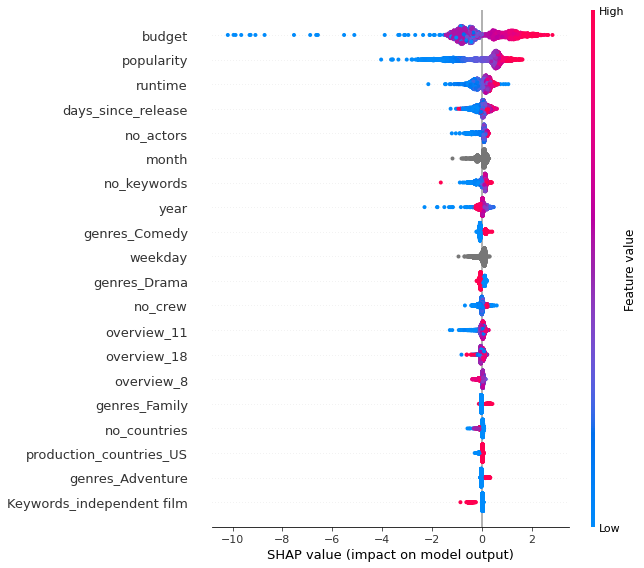

In [14]:
explainer = shap.TreeExplainer(cat)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

In [15]:
lgb_t = lgb.LGBMRegressor(learning_rate = 0.001,n_estimators = 200 ,max_depth = 10)

In [16]:
pred_test_t,log_rmse_train_t,log_rmse_val_t = model_train(lgb_t)
print('train score:',np.mean(log_rmse_train_t), 'validation score:',np.mean(log_rmse_val_t))
result = submission(pred_test_t)[0]

100%|██████████| 10/10 [00:14<00:00,  1.40s/it]

train score: 1.638229881917375 validation score: 2.3375100804471587


In [17]:
def model_cat(model):
    for j in tqdm(range(k)):   
        x_train = train.loc[list_of_train_index[j], :]
        x_valid = train.loc[list_of_valid_index[j], :]
        
        y_true_train = y[list_of_train_index[j]]
        y_true_valid = y[list_of_valid_index[j]]

        model.fit(x_train,y_true_train,cat_features = cat_cols)
        preds_train[:,j] = model.predict(train)
        preds_val[:,j] = model.predict(x_valid)
        preds_test[:,j] = model.predict(test)
        
        log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
        log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
    return preds_test,log_rmse_train,log_rmse_val

In [18]:
pred_test_cat,log_rmse_train_cat,log_rmse_val_cat = model_cat(cat)
print('train score:',log_rmse_train_cat,'validation score:',log_rmse_val_cat)
result = submission(pred_test_cat)[0]

  0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.0479
0:	learn: 2.9702722	total: 14.1ms	remaining: 14s
1:	learn: 2.9148080	total: 27.4ms	remaining: 13.7s
2:	learn: 2.8658595	total: 40.3ms	remaining: 13.4s
3:	learn: 2.8203237	total: 57ms	remaining: 14.2s
4:	learn: 2.7776005	total: 76.9ms	remaining: 15.3s
5:	learn: 2.7382583	total: 90.2ms	remaining: 14.9s
6:	learn: 2.7047165	total: 103ms	remaining: 14.6s
7:	learn: 2.6685662	total: 121ms	remaining: 15.1s
8:	learn: 2.6380332	total: 134ms	remaining: 14.8s
9:	learn: 2.6062421	total: 147ms	remaining: 14.5s
10:	learn: 2.5727690	total: 159ms	remaining: 14.3s
11:	learn: 2.5441574	total: 180ms	remaining: 14.8s
12:	learn: 2.5181492	total: 193ms	remaining: 14.7s
13:	learn: 2.4916181	total: 206ms	remaining: 14.5s
14:	learn: 2.4735289	total: 210ms	remaining: 13.8s
15:	learn: 2.4557681	total: 223ms	remaining: 13.7s
16:	learn: 2.4332726	total: 242ms	remaining: 14s
17:	learn: 2.4104380	total: 255ms	remaining: 13.9s
18:	learn: 2.3917902	total: 270ms	remaining: 14s
19:	learn: 2.37

 10%|█         | 1/10 [00:15<02:15, 15.11s/it]

Learning rate set to 0.0479
0:	learn: 2.9900905	total: 13.9ms	remaining: 13.9s
1:	learn: 2.9338416	total: 27.3ms	remaining: 13.6s
2:	learn: 2.8847036	total: 43.9ms	remaining: 14.6s
3:	learn: 2.8414246	total: 57ms	remaining: 14.2s
4:	learn: 2.7964307	total: 69.6ms	remaining: 13.8s
5:	learn: 2.7595136	total: 82.2ms	remaining: 13.6s
6:	learn: 2.7218674	total: 94.7ms	remaining: 13.4s
7:	learn: 2.6866927	total: 109ms	remaining: 13.6s
8:	learn: 2.6547546	total: 122ms	remaining: 13.5s
9:	learn: 2.6242021	total: 135ms	remaining: 13.4s
10:	learn: 2.5936546	total: 148ms	remaining: 13.3s
11:	learn: 2.5672398	total: 174ms	remaining: 14.3s
12:	learn: 2.5432610	total: 188ms	remaining: 14.3s
13:	learn: 2.5187557	total: 202ms	remaining: 14.2s
14:	learn: 2.5000090	total: 206ms	remaining: 13.5s
15:	learn: 2.4780466	total: 219ms	remaining: 13.5s
16:	learn: 2.4545866	total: 233ms	remaining: 13.5s
17:	learn: 2.4320001	total: 245ms	remaining: 13.4s
18:	learn: 2.4125181	total: 262ms	remaining: 13.5s
19:	lear

 20%|██        | 2/10 [00:30<02:00, 15.11s/it]

Learning rate set to 0.0479
0:	learn: 3.0506399	total: 20.3ms	remaining: 20.2s
1:	learn: 2.9965942	total: 33.7ms	remaining: 16.8s
2:	learn: 2.9469385	total: 47.1ms	remaining: 15.7s
3:	learn: 2.9024079	total: 60.4ms	remaining: 15s
4:	learn: 2.8594241	total: 73.5ms	remaining: 14.6s
5:	learn: 2.8228759	total: 91.5ms	remaining: 15.2s
6:	learn: 2.7869192	total: 107ms	remaining: 15.1s
7:	learn: 2.7484116	total: 124ms	remaining: 15.4s
8:	learn: 2.7148205	total: 137ms	remaining: 15.1s
9:	learn: 2.6832657	total: 151ms	remaining: 15s
10:	learn: 2.6494206	total: 164ms	remaining: 14.8s
11:	learn: 2.6201627	total: 184ms	remaining: 15.1s
12:	learn: 2.5923629	total: 197ms	remaining: 15s
13:	learn: 2.5686754	total: 210ms	remaining: 14.8s
14:	learn: 2.5486503	total: 216ms	remaining: 14.2s
15:	learn: 2.5245242	total: 229ms	remaining: 14.1s
16:	learn: 2.5032592	total: 242ms	remaining: 14s
17:	learn: 2.4835434	total: 255ms	remaining: 13.9s
18:	learn: 2.4621760	total: 269ms	remaining: 13.9s
19:	learn: 2.44

 30%|███       | 3/10 [00:45<01:47, 15.36s/it]

996:	learn: 0.9060904	total: 14.1s	remaining: 42.4ms
997:	learn: 0.9055062	total: 14.1s	remaining: 28.2ms
998:	learn: 0.9050336	total: 14.1s	remaining: 14.1ms
999:	learn: 0.9039779	total: 14.1s	remaining: 0us
Learning rate set to 0.0479
0:	learn: 3.0225653	total: 13.8ms	remaining: 13.8s
1:	learn: 2.9674599	total: 28.6ms	remaining: 14.3s
2:	learn: 2.9178391	total: 42.9ms	remaining: 14.3s
3:	learn: 2.8716428	total: 55.8ms	remaining: 13.9s
4:	learn: 2.8278066	total: 68.9ms	remaining: 13.7s
5:	learn: 2.7889867	total: 81.5ms	remaining: 13.5s
6:	learn: 2.7493258	total: 94.6ms	remaining: 13.4s
7:	learn: 2.7146499	total: 107ms	remaining: 13.3s
8:	learn: 2.6779835	total: 120ms	remaining: 13.2s
9:	learn: 2.6509203	total: 134ms	remaining: 13.2s
10:	learn: 2.6190332	total: 148ms	remaining: 13.3s
11:	learn: 2.5895204	total: 162ms	remaining: 13.3s
12:	learn: 2.5609951	total: 188ms	remaining: 14.3s
13:	learn: 2.5386155	total: 206ms	remaining: 14.5s
14:	learn: 2.5148623	total: 219ms	remaining: 14.4s
1

 40%|████      | 4/10 [01:00<01:31, 15.25s/it]

Learning rate set to 0.0479
0:	learn: 3.0201552	total: 13.8ms	remaining: 13.8s
1:	learn: 2.9680009	total: 28.5ms	remaining: 14.2s
2:	learn: 2.9209473	total: 41.4ms	remaining: 13.8s
3:	learn: 2.8760748	total: 54.7ms	remaining: 13.6s
4:	learn: 2.8312822	total: 67.9ms	remaining: 13.5s
5:	learn: 2.7913100	total: 81.8ms	remaining: 13.5s
6:	learn: 2.7545840	total: 94.9ms	remaining: 13.5s
7:	learn: 2.7171157	total: 108ms	remaining: 13.4s
8:	learn: 2.6828393	total: 121ms	remaining: 13.4s
9:	learn: 2.6528875	total: 138ms	remaining: 13.6s
10:	learn: 2.6233651	total: 152ms	remaining: 13.6s
11:	learn: 2.5962685	total: 165ms	remaining: 13.6s
12:	learn: 2.5679888	total: 186ms	remaining: 14.1s
13:	learn: 2.5426826	total: 199ms	remaining: 14s
14:	learn: 2.5196160	total: 212ms	remaining: 13.9s
15:	learn: 2.4978412	total: 226ms	remaining: 13.9s
16:	learn: 2.4774037	total: 238ms	remaining: 13.8s
17:	learn: 2.4573873	total: 251ms	remaining: 13.7s
18:	learn: 2.4402295	total: 268ms	remaining: 13.8s
19:	lear

 50%|█████     | 5/10 [01:16<01:16, 15.27s/it]

998:	learn: 0.9693227	total: 13.9s	remaining: 13.9ms
999:	learn: 0.9682699	total: 13.9s	remaining: 0us
Learning rate set to 0.0479
0:	learn: 3.0530993	total: 15.7ms	remaining: 15.7s
1:	learn: 3.0041855	total: 29.2ms	remaining: 14.6s
2:	learn: 2.9592389	total: 42.4ms	remaining: 14.1s
3:	learn: 2.9118020	total: 55.5ms	remaining: 13.8s
4:	learn: 2.8671512	total: 68.2ms	remaining: 13.6s
5:	learn: 2.8259842	total: 81.5ms	remaining: 13.5s
6:	learn: 2.7858005	total: 95ms	remaining: 13.5s
7:	learn: 2.7561259	total: 111ms	remaining: 13.7s
8:	learn: 2.7219133	total: 124ms	remaining: 13.6s
9:	learn: 2.6889437	total: 137ms	remaining: 13.6s
10:	learn: 2.6596191	total: 150ms	remaining: 13.5s
11:	learn: 2.6302464	total: 163ms	remaining: 13.4s
12:	learn: 2.6043213	total: 176ms	remaining: 13.4s
13:	learn: 2.5776194	total: 190ms	remaining: 13.4s
14:	learn: 2.5524793	total: 211ms	remaining: 13.8s
15:	learn: 2.5284616	total: 224ms	remaining: 13.8s
16:	learn: 2.5085510	total: 237ms	remaining: 13.7s
17:	lea

 60%|██████    | 6/10 [01:38<01:10, 17.62s/it]

Learning rate set to 0.0479
0:	learn: 3.0034832	total: 33.1ms	remaining: 33.1s
1:	learn: 2.9565453	total: 67.5ms	remaining: 33.7s
2:	learn: 2.9045376	total: 133ms	remaining: 44.1s
3:	learn: 2.8618745	total: 182ms	remaining: 45.4s
4:	learn: 2.8205748	total: 220ms	remaining: 43.8s
5:	learn: 2.7828012	total: 251ms	remaining: 41.5s
6:	learn: 2.7479508	total: 318ms	remaining: 45.1s
7:	learn: 2.7181924	total: 392ms	remaining: 48.6s
8:	learn: 2.6848349	total: 427ms	remaining: 47s
9:	learn: 2.6567231	total: 473ms	remaining: 46.9s
10:	learn: 2.6297253	total: 518ms	remaining: 46.6s
11:	learn: 2.6062624	total: 568ms	remaining: 46.7s
12:	learn: 2.5799789	total: 596ms	remaining: 45.3s
13:	learn: 2.5570701	total: 622ms	remaining: 43.8s
14:	learn: 2.5326980	total: 649ms	remaining: 42.6s
15:	learn: 2.5091075	total: 670ms	remaining: 41.2s
16:	learn: 2.4896061	total: 709ms	remaining: 41s
17:	learn: 2.4670199	total: 739ms	remaining: 40.3s
18:	learn: 2.4466544	total: 782ms	remaining: 40.4s
19:	learn: 2.43

 70%|███████   | 7/10 [01:55<00:51, 17.33s/it]

997:	learn: 0.9331257	total: 15.1s	remaining: 30.2ms
998:	learn: 0.9325919	total: 15.1s	remaining: 15.1ms
999:	learn: 0.9315652	total: 15.1s	remaining: 0us
Learning rate set to 0.0479
0:	learn: 3.0226244	total: 13.7ms	remaining: 13.6s
1:	learn: 2.9721446	total: 33.5ms	remaining: 16.7s
2:	learn: 2.9227700	total: 48.7ms	remaining: 16.2s
3:	learn: 2.8809032	total: 60.9ms	remaining: 15.2s
4:	learn: 2.8397885	total: 73.1ms	remaining: 14.5s
5:	learn: 2.8045427	total: 85.3ms	remaining: 14.1s
6:	learn: 2.7698717	total: 97.7ms	remaining: 13.9s
7:	learn: 2.7332227	total: 110ms	remaining: 13.6s
8:	learn: 2.6969425	total: 125ms	remaining: 13.7s
9:	learn: 2.6634731	total: 137ms	remaining: 13.6s
10:	learn: 2.6339719	total: 149ms	remaining: 13.4s
11:	learn: 2.6094945	total: 170ms	remaining: 14s
12:	learn: 2.5838919	total: 183ms	remaining: 13.9s
13:	learn: 2.5591110	total: 195ms	remaining: 13.8s
14:	learn: 2.5338442	total: 212ms	remaining: 13.9s
15:	learn: 2.5106405	total: 225ms	remaining: 13.8s
16:	l

 80%|████████  | 8/10 [02:10<00:33, 16.58s/it]

996:	learn: 0.9322638	total: 13.4s	remaining: 40.2ms
997:	learn: 0.9308489	total: 13.4s	remaining: 26.8ms
998:	learn: 0.9297537	total: 13.4s	remaining: 13.4ms
999:	learn: 0.9288840	total: 13.4s	remaining: 0us
Learning rate set to 0.0479
0:	learn: 3.0003910	total: 20.4ms	remaining: 20.3s
1:	learn: 2.9537187	total: 32.9ms	remaining: 16.4s
2:	learn: 2.9096952	total: 45.4ms	remaining: 15.1s
3:	learn: 2.8635302	total: 57.8ms	remaining: 14.4s
4:	learn: 2.8243880	total: 70.7ms	remaining: 14.1s
5:	learn: 2.7831974	total: 88.7ms	remaining: 14.7s
6:	learn: 2.7439034	total: 101ms	remaining: 14.3s
7:	learn: 2.7058657	total: 114ms	remaining: 14.1s
8:	learn: 2.6735314	total: 127ms	remaining: 13.9s
9:	learn: 2.6395287	total: 139ms	remaining: 13.8s
10:	learn: 2.6092278	total: 152ms	remaining: 13.7s
11:	learn: 2.5840767	total: 165ms	remaining: 13.6s
12:	learn: 2.5546712	total: 186ms	remaining: 14.1s
13:	learn: 2.5325034	total: 203ms	remaining: 14.3s
14:	learn: 2.5106378	total: 216ms	remaining: 14.2s
15

 90%|█████████ | 9/10 [02:25<00:16, 16.14s/it]

Learning rate set to 0.0479
0:	learn: 3.0358240	total: 12.8ms	remaining: 12.8s
1:	learn: 2.9841312	total: 25.2ms	remaining: 12.6s
2:	learn: 2.9360326	total: 37.7ms	remaining: 12.5s
3:	learn: 2.8902043	total: 50.4ms	remaining: 12.6s
4:	learn: 2.8493895	total: 64.1ms	remaining: 12.8s
5:	learn: 2.8097067	total: 77.8ms	remaining: 12.9s
6:	learn: 2.7724664	total: 91.3ms	remaining: 13s
7:	learn: 2.7440126	total: 103ms	remaining: 12.8s
8:	learn: 2.7101545	total: 116ms	remaining: 12.7s
9:	learn: 2.6830987	total: 128ms	remaining: 12.7s
10:	learn: 2.6487025	total: 141ms	remaining: 12.7s
11:	learn: 2.6204473	total: 154ms	remaining: 12.7s
12:	learn: 2.5906863	total: 166ms	remaining: 12.6s
13:	learn: 2.5659585	total: 199ms	remaining: 14s
14:	learn: 2.5424084	total: 219ms	remaining: 14.4s
15:	learn: 2.5173664	total: 235ms	remaining: 14.4s
16:	learn: 2.4959024	total: 248ms	remaining: 14.3s
17:	learn: 2.4762072	total: 260ms	remaining: 14.2s
18:	learn: 2.4589214	total: 272ms	remaining: 14s
19:	learn: 2

100%|██████████| 10/10 [02:40<00:00, 16.02s/it]

train score: [1.0728931310702368, 1.041834774236138, 0.971288595071095, 1.0158703498550858, 1.0233939795013742, 0.9633629511252465, 1.0315564288685597, 0.9957520836034988, 1.022027939781452, 0.9814543147575917, 1.1719162667684857, 1.129954932937757, 1.062077137512664, 1.1104983000070157, 1.1541499899564596, 1.1020893648563117, 1.1344460059582602, 1.125258494405632, 1.1236153323677025, 1.10710449225633, 2.7834568000353634, 2.7817729745476014, 2.778467477618368, 2.7792594877458314, 2.778905090986017, 2.774526962002684, 2.783347140228991, 2.782698684941319, 2.7815430300883635, 2.7823739444298226, 1.1719162667684857, 1.129954932937757, 1.062077137512664, 1.1104983000070157, 1.1541499899564596, 1.1020893648563117, 1.1344460059582602, 1.125258494405632, 1.1236153323677025, 1.10710449225633] validation score: [2.474996362620094, 2.3175917570757396, 1.930024213808468, 2.1304547145417407, 2.211890656574253, 1.9159132829590544, 2.2765963161434697, 2.0496570750220675, 2.212621826445172, 1.9660976

In [ ]:
# pred_test_cat_tune,log_rmse_train_cat_tune,log_rmse_val_cat_tune = model_cat(pipe_cat)
# print(np.mean(log_rmse_train_cat_tune),np.mean(log_rmse_val_cat_tune))
# result = submission(pred_test_cat_tune)[0]

MODEL could not deal with text data(i.e.: need one-hot encoding)

In [19]:
train= pd.read_csv('processed_train.csv')
test = pd.read_csv('processed_test.csv')
train = train.drop(columns=['Unnamed: 0'])
test = test.drop(columns=['Unnamed: 0'])
y = pd.read_csv('label_train.csv')
y = y.squeeze()
test.fillna(test.mode().iloc[0], inplace = True) #fill in missing value with mode
cat_cols = ['original_language','status','weekday','day','month']

In [20]:
k=10
kf = KFold(n_splits=k,
            shuffle=True,
            random_state=int(time.time()))

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in kf.split(np.zeros(len(y)), # Placeholder (dummy input)
                                          y): # True input
    
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)

In [21]:
preds_train = np.zeros([len(train),k])
preds_val = np.zeros([len(list_of_valid_index[0]),k])
preds_test = np.zeros([len(test),k])

log_rmse_train = []
log_rmse_val = []

In [22]:
def model_train(model):
    for j in tqdm(range(k)):   
        x_train = train.loc[list_of_train_index[j], :]
        x_valid = train.loc[list_of_valid_index[j], :]
        
        y_true_train = y[list_of_train_index[j]]
        y_true_valid = y[list_of_valid_index[j]]

        model.fit(x_train,y_true_train)
        preds_train[:,j] = model.predict(train)
        preds_val[:,j] = model.predict(x_valid)
        preds_test[:,j] = model.predict(test)
        
        log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
        log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
    return preds_test,log_rmse_train,log_rmse_val

In [23]:
def submission(preds_test):
    final_preds = preds_test.mean(axis=1)
    sub = pd.read_csv('sample_submission.csv')
    sub.revenue = np.exp(final_preds)
    sub.to_csv('sub_hist.csv',index=False)
    return final_preds,sub

In [24]:
#train[train.select_dtypes("float64").columns.to_list()] = train[train.select_dtypes("float64").columns.to_list()].apply(lambda x: np.float32(x))

In [25]:
#test[test.select_dtypes("float64").columns.to_list()] = test[test.select_dtypes("float64").columns.to_list()].apply(lambda x: np.float32(x))

In [26]:
test.select_dtypes("float64").columns

Index(['budget', 'popularity', 'runtime', 'days_since_release', 'weekday',
       'day', 'month', 'year', 'overview_0', 'overview_1', 'overview_2',
       'overview_3', 'overview_4', 'overview_5', 'overview_6', 'overview_7',
       'overview_8', 'overview_9', 'overview_10', 'overview_11', 'overview_12',
       'overview_13', 'overview_14', 'overview_15', 'overview_16',
       'overview_17', 'overview_18', 'overview_19', 'x0_ar', 'x0_bn', 'x0_cn',
       'x0_cs', 'x0_da', 'x0_de', 'x0_el', 'x0_en', 'x0_es', 'x0_fa', 'x0_fi',
       'x0_fr', 'x0_he', 'x0_hi', 'x0_hu', 'x0_id', 'x0_it', 'x0_ja', 'x0_ko',
       'x0_ml', 'x0_mr', 'x0_nb', 'x0_nl', 'x0_no', 'x0_pl', 'x0_pt', 'x0_ro',
       'x0_ru', 'x0_sr', 'x0_sv', 'x0_ta', 'x0_te', 'x0_tr', 'x0_ur', 'x0_vi',
       'x0_zh', 'x0_Released', 'x0_Rumored'],
      dtype='object')

In [27]:
test.fillna(test.mode().iloc[0], inplace = True)

In [28]:
rf = RandomForestRegressor()
pred_test_rf,log_rmse_train_rf,log_rmse_val_rf = model_train(rf)
print('train score:',np.mean(log_rmse_train_rf), 'vali score:',np.mean(log_rmse_val_rf))
result = submission(pred_test_rf)[0]

100%|██████████| 10/10 [00:49<00:00,  4.97s/it]

train score: 0.9957870108471992 vali score: 2.0937081036350618


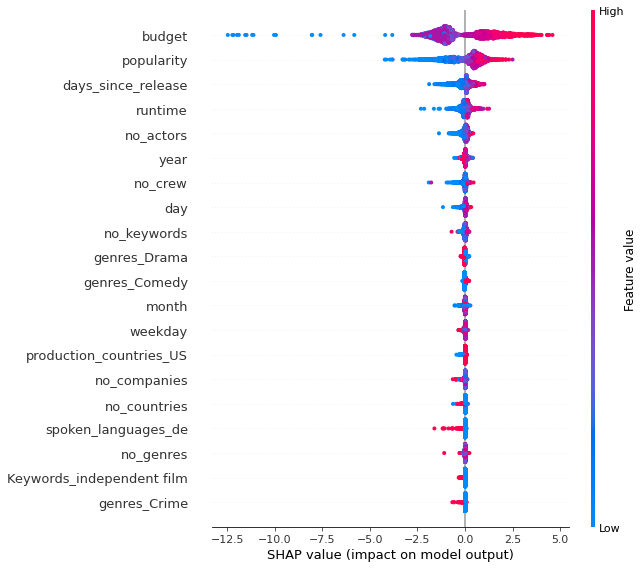

In [29]:
explainer = shap.TreeExplainer(rf)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

Hist

In [30]:
hist = HistGradientBoostingRegressor()
pred_test_hist,log_rmse_train_hist,log_rmse_val_hist = model_train(hist)
print('train score:',np.mean(log_rmse_train_hist),'val score:', np.mean(log_rmse_val_hist))
result = submission(pred_test_hist)[0]

100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

train score: 1.121798938464079 val score: 2.09374322805545


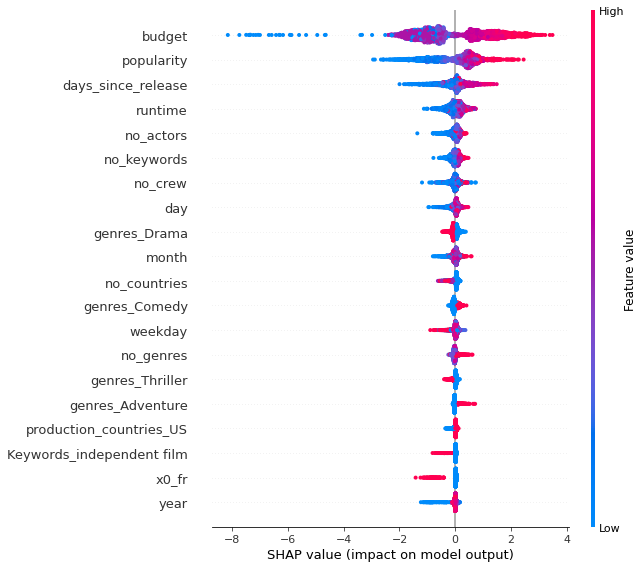

In [31]:
explainer = shap.TreeExplainer(hist)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

GB

In [32]:
gb = GradientBoostingRegressor()
pred_test_gb,log_rmse_train_gb,log_rmse_val_gb = model_train(gb)
print('train score:',np.mean(log_rmse_train_gb), 'val score:',np.mean(log_rmse_val_gb))
result = submission(pred_test_gb)[0]

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]

train score: 1.3319548001745114 val score: 2.0959718350760435


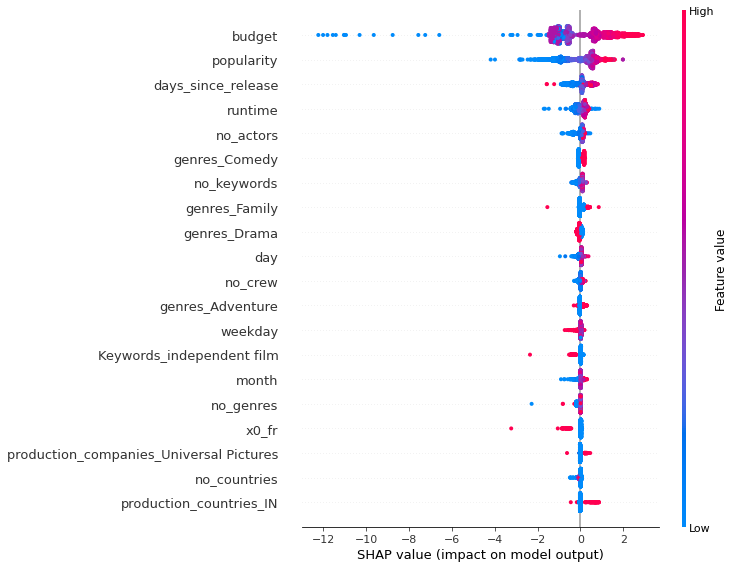

In [33]:
explainer = shap.TreeExplainer(gb)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)

XGB

In [34]:
xgb = XGBRegressor()
pred_test_xgb,log_rmse_train_xgb,log_rmse_val_xgb = model_train(xgb)
print('train score:',np.mean(log_rmse_train_xgb), 'val score:',np.mean(log_rmse_val_xgb))
result = submission(pred_test_xgb)[0]

  0%|          | 0/10 [00:00<?, ?it/s]

[01:22:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 10%|█         | 1/10 [00:01<00:12,  1.43s/it]

[01:22:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 20%|██        | 2/10 [00:02<00:10,  1.36s/it]

[01:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 30%|███       | 3/10 [00:04<00:09,  1.34s/it]

[01:22:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 40%|████      | 4/10 [00:05<00:07,  1.33s/it]

[01:22:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 50%|█████     | 5/10 [00:06<00:06,  1.33s/it]

[01:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 60%|██████    | 6/10 [00:08<00:05,  1.32s/it]

[01:22:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 70%|███████   | 7/10 [00:09<00:03,  1.32s/it]

[01:22:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 80%|████████  | 8/10 [00:10<00:02,  1.32s/it]

[01:22:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


 90%|█████████ | 9/10 [00:11<00:01,  1.31s/it]

[01:22:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [00:13<00:00,  1.32s/it]

train score: 1.4453889011780838 val score: 2.0915006095827957


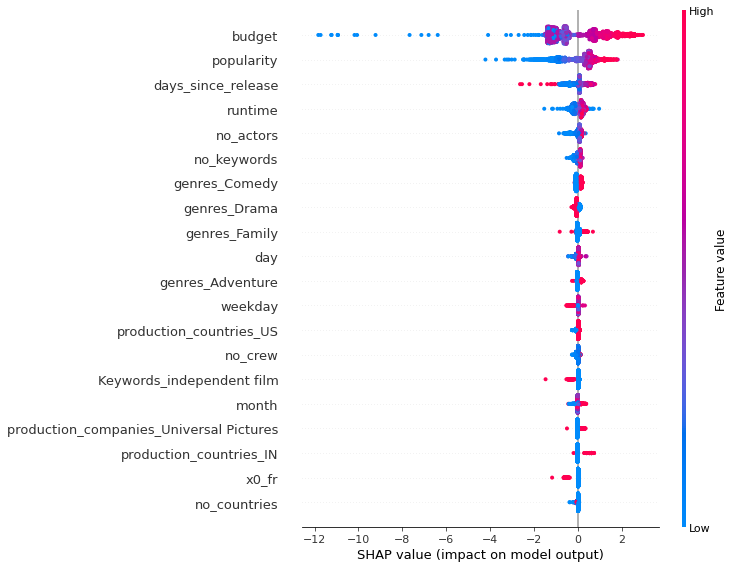

In [35]:
explainer = shap.TreeExplainer(xgb)  
shap_values = explainer.shap_values(train) 
shap.summary_plot(shap_values, train)